# Amatsiko: Which Language Gets Read First?
Comparing Kinyarwanda- and English-Language Pageviews Time Series, for Rwanda-related Wikipedia Articles

https://plotly.com/python/time-series/

## setup

##### basic

In [96]:
# imports
import time, os, numpy as np
import pandas as pd, datetime as dt
import dateutil.relativedelta as reladelt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

import plotly.express as px, plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt

from mwviews.api import PageviewsClient

In [ ]:
# initialize api instance
pvc = PageviewsClient(user_agent="<steven@bhrdwj.net> Time Series Comparison of Articles Between Wikipedias")

##### name the desired data, so can obtain it

In [4]:
# list article titles for querying api
article_pairs = [
    ('Rwanda', 'Rwanda'),
    ('Paul_Kagame', 'Paul_Kagame'),
    ('Umuganda', 'Umuganda'),
    ('Uburezi_mu_Rwanda', 'Education_in_Rwanda'),
    ('Kigali', 'Kigali'),
    ('Ubukungu_bw%27U_Rwanda', 'Economy_of_Rwanda'),
    ('Ikinyarwanda', 'Kinyarwanda'),
    ('Rose_Kabuye', 'Rose_Kabuye'),
    ('Louise_Mushikiwabo', 'Louise_Mushikiwabo'),
    ('Agnes_Binagwaho', 'Agnes_Binagwaho'),
    ('Paul_Rusesabagina', 'Paul_Rusesabagina')
]
rw_articles = [i for i,j in article_pairs]
en_articles = [j for i,j in article_pairs]
article_tups = [('rw', i) for i in rw_articles] + [('en', i) for i in en_articles]
article_idx = pd.Index(article_tups)

In [5]:
# list first-of-each-month dates as the api likes ~31-day queries
date = dt.date.today()
earliest = dt.date(date.year,1,1) - reladelt.relativedelta(years=5)
first_of_month = dt.date(date.year, date.month,1)
dates = [date, first_of_month]
while date > earliest:
    date = dates[-1] - reladelt.relativedelta(months=1)
    dates.append(date)
dates = pd.Series(dates)

In [30]:
# construct the panel dataframe
date_idx = pd.date_range(start=min(dates), end=max(dates))
panel = pd.DataFrame(index=date_idx, columns=article_idx)

##### get the pageviews data from the api
*disabled from code to markdown, to reuse saved csv*  
*accessing data from api took 8 minutes, requesting 5 1/2 years of pageviews*

```python
starts_ends = list(zip(dates.to_list(), dates.shift(1).to_list()))[1:]
article_dict = {'rw': rw_articles, 'en': en_articles}
for start,end in starts_ends:
    time.sleep(2)
    for w in ['rw', 'en']:
        response = pvc.article_views(
            project=f'{w}.wikipedia', articles=article_dict[w], start=start, end=end
        )
        for date in response:
            dateidx = pd.to_datetime(date)
            for article in response[dateidx]:
                panel.loc[dateidx, (w, article)] = response[date][article]
panel.to_csv('pageview_table.csv')
```

#####  clean and peek

In [34]:
# read_csv the time series and rearrange multiindex
panel = pd.read_csv('pageview_table.csv', header=[0,1], skipinitialspace=True, index_col=0)
l = []
num_articles = panel.shape[1]//2
for i in range(num_articles*2):
    article_num = i % num_articles
    l.append((article_num, article_tups[i][0], article_tups[i][1]))
panel.columns = pd.Index(l)
panel.sort_index(axis=1, level=[0,1], inplace=True)

In [37]:
panel.head(2)

0                  1                    2            \
                en     rw          en          rw       en       rw   
            Rwanda Rwanda Paul_Kagame Paul_Kagame Umuganda Umuganda   
2017-01-01  2711.0   63.0       878.0        15.0      NaN      NaN   
2017-01-02  2911.0   87.0      1017.0        13.0      NaN      NaN   

                            3                        4          ...  \
                            en                rw     en     rw  ...   
           Education_in_Rwanda Uburezi_mu_Rwanda Kigali Kigali  ...   
2017-01-01                46.0               NaN  404.0   11.0  ...   
2017-01-02                71.0               NaN  641.0    6.0  ...   

                    6                        7               \
                    en           rw          en          rw   
           Kinyarwanda Ikinyarwanda Rose_Kabuye Rose_Kabuye   
2017-01-01       141.0         17.0        11.0         NaN   
2017-01-02       174.0         19.0        11.0         NaN   

                           8                                  9   \
                           en                 rw              en   
           Louise_Mushikiwabo Louise_Mushikiwabo Agnes_Binagwaho   
2017-01-01               17.0                NaN            17.0   
2017-01-02               25.0                NaN             9.0   

                                          10                    
                        rw                en                rw  
           Agnes_Binagwaho Paul_Rusesabagina Paul_Rusesabagina  
2017-01-01             NaN             517.0               NaN  
2017-01-02             NaN             686.0               NaN  

[2 rows x 22 columns]

In [25]:
# prep the Paul_Kagame pageviews for plotting
pk = panel[0]
pk = pk.droplevel(1,axis=1)

In [38]:
pk.head(2)

,en,rw
2017-01-01,2711.0,63.0
2017-01-02,2911.0,87.0


## visualize

In [23]:
# plot the Paul_Kagame pageviews (pk)
fig = px.line(pk, y=['en', 'rw'], log_y=True,
              title='Pageviews of "Paul_Kagame" Article on en. and rw.wikipedia')
fig.update_layout(hovermode="x unified")
fig.show()

## regress / predict

##### prep Paul_Kagame data for regression (pkts)

In [75]:
# center around 7-day mean
pkts = pk - pkts.rolling(7).mean()
pkts = pkts.dropna()

In [78]:
# plot the centered Paul_Kagame pageviews (pkts)
fig = make_subplots(rows=2, cols=1)

fig.append_trace(go.Scatter(
    x=pkts.index, y=pkts['en'], name='en'
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=pkts.index, y=pkts['rw'], name='rw'
), row=2, col=1)

# fig = px.line(pkts, y=['en', 'rw'],
#               title='Pageviews of "Paul_Kagame" Article on en. and rw.wikipedia')
fig.update_layout(hovermode="x unified")
fig.show()

##### assess autocorrelation

In [130]:
en = pkts['en'].rename('en')
rw = pkts['rw'].rename('rw')

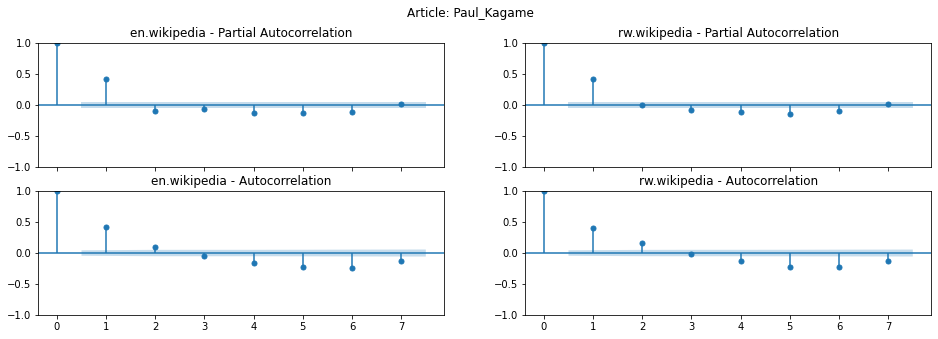

In [171]:
fig, [[ax_en_pacf, ax_rw_pacf], [ax_en_acf, ax_rw_acf]] = (
    plt.subplots(nrows=2, ncols=2, figsize=(16,5), sharex=True)
)
sm.graphics.tsa.plot_pacf(en, lags=7, ax=ax_en_pacf, title='en.wikipedia - Partial Autocorrelation', method='ywm')
sm.graphics.tsa.plot_pacf(rw, lags=7, ax=ax_rw_pacf, title='rw.wikipedia - Partial Autocorrelation', method='ywm')
sm.graphics.tsa.plot_acf(en, lags=7, ax=ax_en_acf, title='en.wikipedia - Autocorrelation')
sm.graphics.tsa.plot_acf(rw, lags=7, ax=ax_rw_acf, title='rw.wikipedia - Autocorrelation')

plt.suptitle('Article: Paul_Kagame')
plt.show()

##### Plot preds over actuals

In [133]:
# make lags for use as exogenous vars 
en1 = en.shift(1).dropna().rename('en1')
rw1 = rw.shift(1).dropna().rename('rw1').loc[en1.index]
en = en.loc[en1.index]
rw = rw.loc[en1.index]

# initialize models
mod_en_rw = tsa.arima.ARIMA(endog=en, exog=rw1, order=(1, 0, 1), freq='D')
mod_rw_en = tsa.arima.ARIMA(endog=rw, exog=en1, order=(1, 0, 1), freq='D')

/home/bhrdwj/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/bhrdwj/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [134]:
res_en_rw = mod_en_rw.fit()
res_rw_en = mod_rw_en.fit()

In [163]:
preds_en_rw = pd.Series(res_en_rw.forecasts.flatten(), index=en.index, name='preds')

# pd.concat((en, preds_en_rw), axis=1)

,en,preds
2017-01-26,305.988738,-21.828524
2017-01-27,-150.710411,189.486790
2017-01-28,-352.126405,-103.219696
2017-01-29,-178.830657,-97.363661
2017-01-30,57.605057,-65.189817
...,...,...
2022-06-01,1133.303696,390.788386
2022-06-02,413.166584,448.256098
2022-06-03,-334.399391,99.151574
2022-06-04,-708.109826,-187.390694


In [151]:
res_en_rw.forecasts_error

array([[ 327.81726241, -340.19720096, -248.90670947, ..., -433.55096532,
        -520.71913173,  265.41914425]])

In [147]:
pd.concat((res_en_rw.params, res_en_rw.pvalues), axis=1, keys=['coeffs', 'pvalues'])

,coeffs,pvalues
const,1.962903e+00,9.871780e-01
rw1,1.677418e+00,5.376107e-01
ar.L1,2.675195e-01,1.829304e-35
ma.L1,1.930208e-01,3.103505e-17
sigma2,3.550210e+06,0.000000e+00


In [ ]:
# try using rw
pkts = pkts.loc[:, [(0,'en'), (0,'rw'), (2,'rw'), (3,'rw')]]

en = pkts[(0,'en')]
pkts.loc[:,(0,'en')] = en * (en > 0.15) # low-pass filter

rw = pkts.iloc[:,1:]
pkts.iloc[:,1:] = rw * (rw > 0.2) # low-pass filter

In [195]:
y = pk[0]
X = pk[[1,2,3]]
ytr, yte, Xtr, Xte = train_test_split(y, X, test_size=.3, shuffle=True)